# 2. Homework assignment - Clustering

### 1. Ward Hierarchical Clustering on an image of coins

Generate data

Resize it to 20% of the original size to speed up the processing Applying a Gaussian filter for smoothing prior to down-scaling reduces aliasing artifacts.



In [1]:
from skimage.data import coins

orig_coins = coins()

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)

X = np.reshape(rescaled_coins, (-1, 1))

Define structure of the data

Pixels are connected to their neighbors.

In [3]:
from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)

Compute clustering

In [4]:
import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27  # number of regions
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
ward_labels = np.reshape(ward.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {ward_labels.size}")
print(f"Number of clusters: {np.unique(ward_labels).size}")

Compute structured hierarchical clustering...
Elapsed time: 1.107s
Number of pixels: 4697
Number of clusters: 27


Plot the results on an image

Agglomerative clustering is able to segment each coin however, we have had to use a n_cluster larger than the number of coins because the segmentation is finding a large in the background.



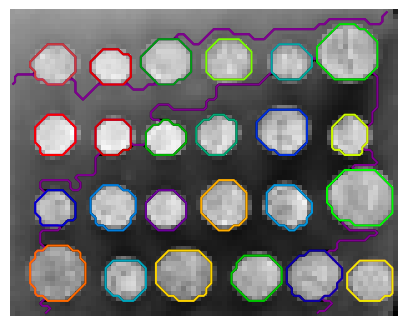

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        ward_labels == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

### 2. K-Means Clustering 

In [6]:
from sklearn.cluster import KMeans
from scipy.ndimage import sobel

In [7]:
# Loading the image 
orig_coins = coins()

In [8]:
# Preprocessing the image

smoothened_coins = gaussian_filter(orig_coins, sigma=3)

# Rescale the image
rescaled_coins = rescale(smoothened_coins, 0.15, mode="reflect", anti_aliasing=False)

# Compute edges using Sobel filter (gradient-based feature)
edges = sobel(rescaled_coins)

# Stack grayscale intensity and edge feature
X = np.column_stack((rescaled_coins.ravel(), edges.ravel()))

In [9]:
print("K-means clustering...")
st = time.time()
n_clusters = 6  # number of regions

k_means = KMeans(
    n_clusters=n_clusters,
    random_state = 42,
    n_init = 20
)
k_means.fit(X)
k_means_labels = np.reshape(k_means.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {k_means_labels.size}")
print(f"Number of clusters: {np.unique(k_means_labels).size}")

K-means clustering...
Elapsed time: 1.132s
Number of pixels: 2610
Number of clusters: 6


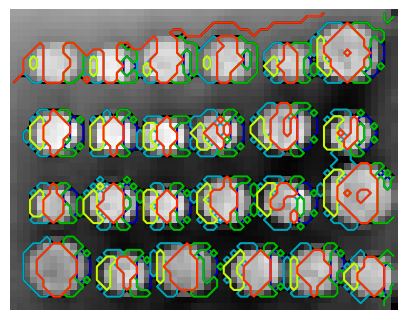

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        k_means_labels == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

### 3. Mean-Shift Clustering

In [11]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [12]:
# Loading the image 
orig_coins = coins()

In [13]:
# Preprocessing the image
smoothened_coins = gaussian_filter(orig_coins, sigma=3)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)
# reshape for clustering
X = np.reshape(rescaled_coins.ravel(), (-1, 1))

In [14]:
# Estimate bandwidth automatically
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

In [15]:
print("Mean-shift clustering...")
st = time.time()
n_clusters = 27  # number of regions

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
meanshift.fit(X)
meanshift_labels = np.reshape(meanshift.labels_, rescaled_coins.shape)

print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {meanshift_labels.size}")
print(f"Number of clusters: {np.unique(meanshift_labels).size}")

Mean-shift clustering...
Elapsed time: 0.914s
Number of pixels: 4697
Number of clusters: 4


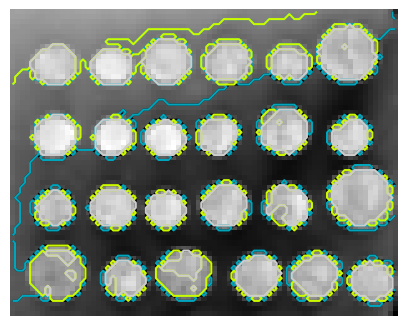

In [16]:
plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in np.unique(meanshift.labels_):  
    plt.contour(
        meanshift_labels == l,
        colors=[plt.cm.nipy_spectral(l / float(np.max(meanshift_labels)))])
  
plt.axis("off")
plt.show()

### 4. Comparisson of Clustering Methods

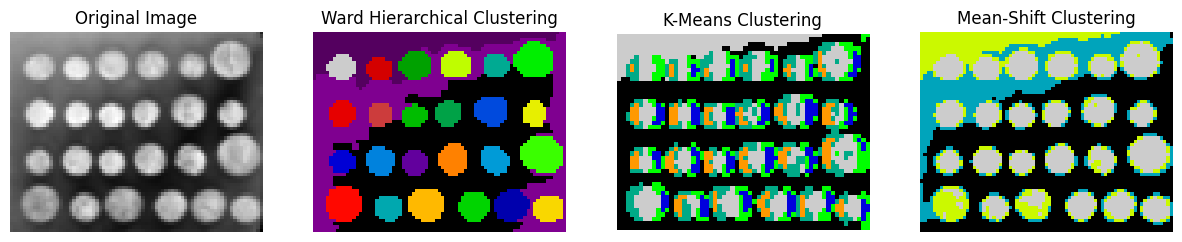

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(rescaled_coins, cmap=plt.cm.gray)
axes[0].set_title("Original Image")
axes[1].imshow(ward_labels, cmap=plt.cm.nipy_spectral)
axes[1].set_title("Ward Hierarchical Clustering")
axes[2].imshow(k_means_labels, cmap=plt.cm.nipy_spectral)
axes[2].set_title("K-Means Clustering")
axes[3].imshow(meanshift_labels, cmap=plt.cm.nipy_spectral)
axes[3].set_title("Mean-Shift Clustering")

for ax in axes:
    ax.axis("off")

plt.show()

- **Ward (Hierarchical Clustering)**:The coins are well-defined, and each one is enclosed neatly within a single segment. It produces clear edges but may over-segment background areas.

- **K-Means Clustering**: K-Means provides faster clustering but does not enforce spatial continuity. It doesn’t do a great job at keeping each coin as one segment, it breaks them up into multiple parts. The background has a lot of unnecessary segmentation.

- **Mean-Shift Clustering**: The coins are mostly well-segmented, but the clusters are a bit inconsistent in size. Some coins have tiny clusters around the edges

**Conclusion:** Hierarchical clustering is best for enforcing spatial consistency, but K-Means is faster but it does not consider spatial relationships, which causes it to break the coins into multiple fragmented segments. Mean-Shift is good for adaptive segmentation but takes longer, and segments are unnecessary in the background.